<a href="https://colab.research.google.com/github/silver612/ML_pathfinder/blob/master/Face_detection_using_hog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

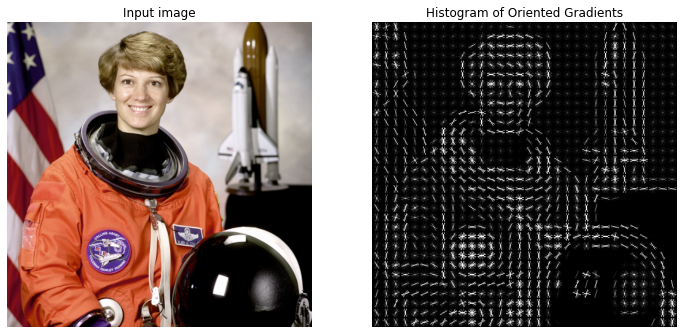

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()



In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images


In [ ]:
from skimage import data, transform, color
from sklearn.feature_extraction.image import PatchExtractor
import numpy as np

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]
 
 
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])


In [ ]:
from skimage import feature   
from itertools import chain
from sklearn.model_selection import train_test_split

X = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])

y = np.zeros(X.shape[0])
y[:positive_patches.shape[0]] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_


0.9924130273871207

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = grid.predict(X_test)
accuracy_score(y_test,y_pred)

0.9928763067813858

In [ ]:
def sliding_window(img, 
                   patch_size=positive_patches[0].shape, 
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
      for j in range(0, img.shape[1] - Ni, jstep):
        patch = img[i:i + Ni, j:j + Nj]
        if scale != 1:
            patch = transform.resize(patch, patch_size)
        yield (i, j), patch


In [ ]:
from skimage import io, transform

img = io.imread('/content/testpic1.jpg',as_gray=True)
img = transform.rescale(img, 0.5)
indices, patches = zip(*sliding_window(img))
patches_hog = np.array([feature.hog(patch) for patch in patches])
labels = model.predict(patches_hog)


In [ ]:
labels.sum()

0.0

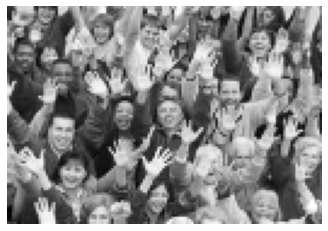

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:            
    ax.add_patch(plt.Rectangle((j, i), 
                               Nj, Ni, 
                               edgecolor='yellow',                                       
                              alpha=0.4, lw=1,                                       
                              facecolor='none'))
plt.show()